In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random as rd
import numpy as np
import math
import gym
from collections import namedtuple, deque

In [18]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

device

'cuda'

In [19]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=self.capacity)

    def clear_batch(self):
        self.memory = deque([], maxlen=self.capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return rd.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [20]:
class Qnet(nn.Module):
    def __init__(self, state_dim, n_action):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
    def forward(self, x):
        return self.model(x)

In [21]:
import matplotlib.pyplot as plt
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(score_list,show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) 
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [22]:
class DQN():
    __BATCH_SIZE = None
    __GAMMA = None
    __EPS_START = None
    __EPS_END = None
    __EPS_DECAY = None
    __TAU = None

    __n_actions = 0
    __device = None

    __policy_net = None
    __target_net = None
    __optimizer = None
    __memory = None
    __steps_done = 0

    def __init__(self, memory_size, batch_size, gamma, tau, observation_space, action_space, device, lr, eps_start = 0.9, eps_end = 0.05, eps_decay = 1000):
        self.__BATCH_SIZE = batch_size
        self.__GAMMA = gamma
        self.__EPS_START = eps_start
        self.__EPS_END = eps_end
        self.__EPS_DECAY = eps_decay
        self.__TAU = tau
        
        self.__device = device
        self.__n_actions = action_space
        self.__policy_net = Qnet(observation_space, action_space).to(device)
        self.__target_net = Qnet(observation_space, action_space).to(device)
        self.__target_net.load_state_dict(self.__policy_net.state_dict())

        self.__optimizer = optim.Adam(self.__policy_net.parameters(), lr=lr, amsgrad=True)
        self.__memory = ReplayMemory(memory_size)
        self.__steps_done = 0

        self.eps_threshold = 0
        self.eps_stack = []
    def select_action(self, state, test = False):
        eps_threshold = self.__EPS_END + (self.__EPS_START - self.__EPS_END) * math.exp(-1. * self.__steps_done / self.__EPS_DECAY)
        self.eps_threshold = eps_threshold
        self.eps_stack.append(eps_threshold)
        self.__steps_done += 1
        if test:
            return self.__policy_net(state).max(-1).indices.view(-1, 1)
        if rd.random() < eps_threshold:
            return torch.tensor([[rd.randint(0, self.__n_actions - 1)]], device=self.__device, dtype=torch.long)
        else:
            return self.__policy_net(state).max(-1).indices.view(-1, 1)
        
    def optimazation(self):
        if len(self.__memory) <= self.__BATCH_SIZE:
            return
        transitions = self.__memory.sample(self.__BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.__device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.__policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.__BATCH_SIZE, device=self.__device)

        with torch.no_grad():
            next_state_values[non_final_mask] = self.__target_net(non_final_next_states).max(1).values

        expected_state_action_values = (next_state_values.reshape(self.__BATCH_SIZE,-1) * self.__GAMMA) + reward_batch # y_j
        
        loss = (expected_state_action_values.detach() - state_action_values)**2
  
        self.__optimizer.zero_grad()
        loss.sum().backward()
        self.__optimizer.step()

        target_net_state_dict = self.__target_net.state_dict()
        policy_net_state_dict = self.__policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.__TAU + target_net_state_dict[key] * (1 - self.__TAU)
        self.__target_net.load_state_dict(target_net_state_dict)
    
    def push_memory(self, state, action, next_state, reward):
        self.__memory.push(state, action, next_state, reward)


In [23]:
SEED = 1234

np.random.seed(SEED)
rd.seed(SEED)
torch.manual_seed(SEED)

env = gym.make('FrozenLake-v1', is_slippery = True)
state, _ = env.reset()
state

0

In [24]:
memory = ReplayMemory(capacity=5000)
episode_reward = []
game_time = []
eps_stack = [] # episode

In [25]:
env.action_space.n, env.observation_space, env.action_space.sample()

(4, Discrete(16), 1)

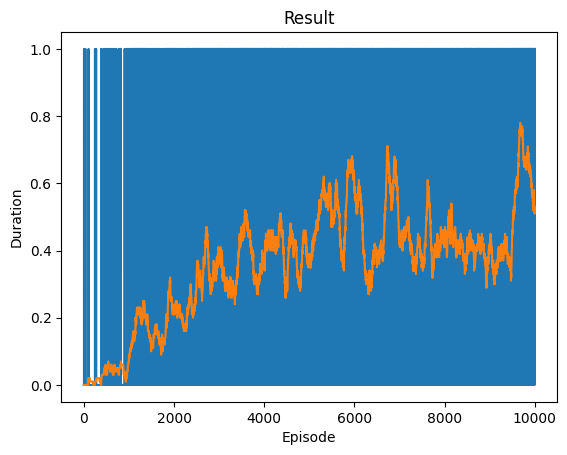

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
Agent = DQN(memory_size=10000,
            batch_size=128,
            gamma=0.99,
            tau=0.01, 
            observation_space=1, 
            action_space=4, 
            device=device, 
            lr = 1e-3,
            eps_decay = 1000)

episode = 10000

for i in range(episode):
    
    state, _ = env.reset(seed = SEED)
    state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)
    

    done = False
    time = 0
    total_reward = 0

    while not done:
        action = Agent.select_action(state).detach()
        next_state, reward, done, truncated, _ = env.step(action.item())
        
        next_state = torch.tensor([next_state], dtype=torch.float32, device=device).unsqueeze(0)
        reward = torch.tensor([reward], dtype=torch.float32, device=device).unsqueeze(0)

        if done:
            next_state = None
        total_reward += reward
        done = done or truncated
        Agent.push_memory(state, action, next_state, reward)
        Agent.optimazation()
        state = next_state
        time += 1
    game_time.append(time)
    episode_reward.append(total_reward.item())
    eps_stack.append(Agent.eps_threshold)
    
    plot_durations(episode_reward,show_result=False)
plot_durations(episode_reward,show_result=True)

    
        

Text(0.5, 1.0, 'episode_step')

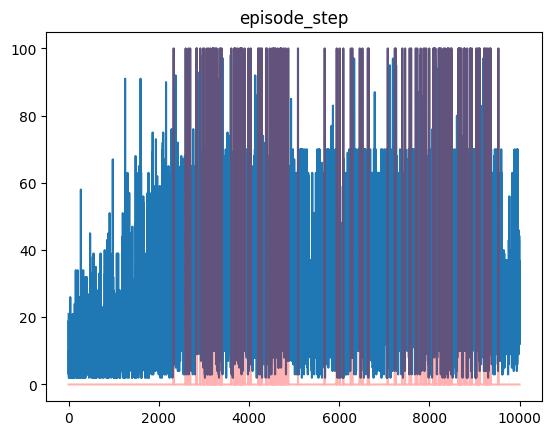

In [45]:
plt.plot(game_time)
tmp = []
for i in game_time:
    if i == 100:
        tmp.append(i)
    else: 
        tmp.append(0)
plt.plot(tmp, c = 'r', alpha = 0.3)
plt.title("episode_step")

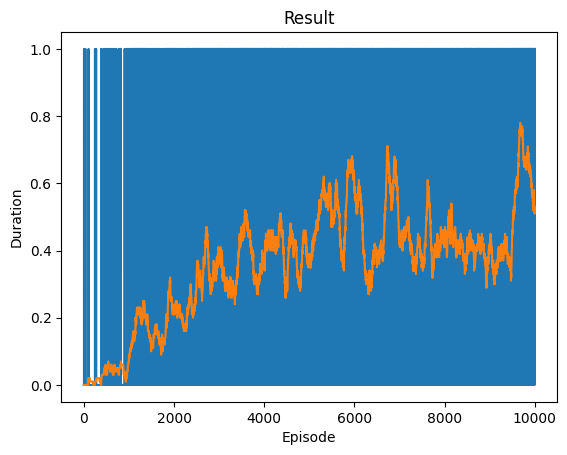

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'eps_Threshold')

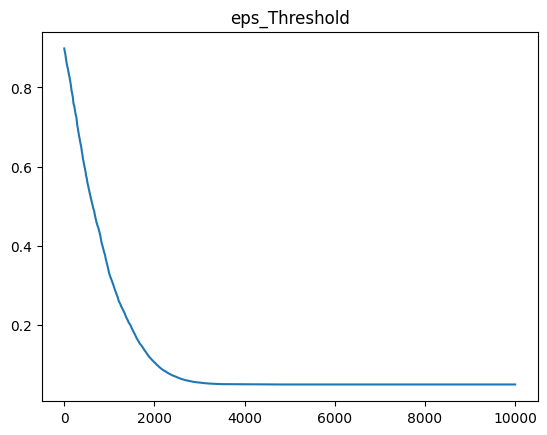

In [40]:
plot_durations(episode_reward,show_result=True)
plt.plot(eps_stack)
plt.title("eps_Threshold")

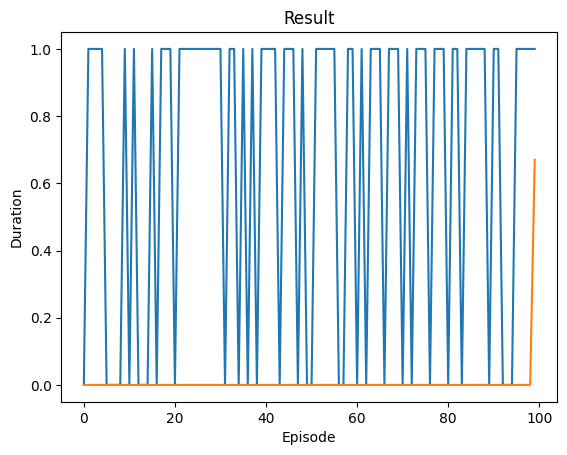

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [33]:
episode = 100
test_episode_reward = []
test_game_time = []
for i in range(episode):
    
    state, _ = env.reset()
    state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)
    

    done = False
    time = 0
    total_reward = 0

    while not done:
        action = Agent.select_action(state, test = True).detach()
        next_state, reward, done, truncated, _ = env.step(action.item())
        next_state = torch.tensor([next_state], dtype=torch.float32, device=device).unsqueeze(0)
        total_reward += reward
        done = done or truncated

        state = next_state
        time += 1
    test_game_time.append(time)
    test_episode_reward.append(total_reward)
    
    plot_durations(test_episode_reward,show_result=False)
plot_durations(test_episode_reward,show_result=True)

In [37]:
sum(test_episode_reward)/100

0.67

Text(0.5, 1.0, 'episode_step')

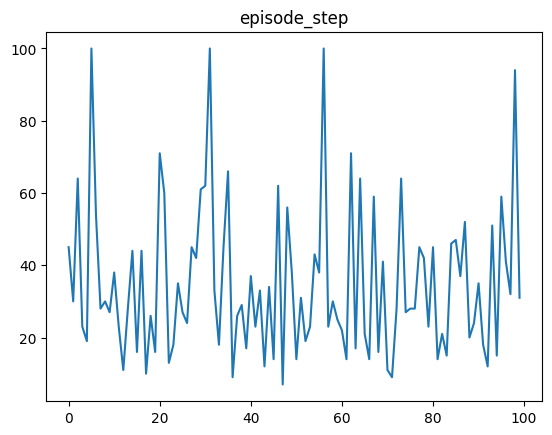

In [46]:
plt.plot(test_game_time)
plt.title("episode_step")